In [1]:
import os
import numpy as np
import re
import sys
import importlib.util
import shutil
import matplotlib.pyplot as plt
import neurite as ne
from tqdm import tqdm


In [2]:
# Import a file from D:\study\graduation project\GP-2025-Strain\Code\ventricular_short_axis_3label\docs\localize.py
base_path = os.getcwd()

# Define the path to the file
file_path = os.path.join(base_path, "../ventricular_short_axis_3label\docs\localize.py")

# Add the directory containing the file to the system path
sys.path.append(os.path.dirname(file_path))

# Import the module
spec = importlib.util.spec_from_file_location("localize", file_path)
localize = importlib.util.module_from_spec(spec)
spec.loader.exec_module(localize)

from localize import Localize

In [3]:
# print Shape of the image from ACDC dataset and Sunnybrook dataset
# Load the numpy file
image = np.load(os.path.join(base_path, "../../Data/ACDC/database/train_numpy/patient101/patient101_frame20_slice_7_ACDC.npy"))
print("Shape of the image from ACDC dataset: ", image.shape)

image = np.load(os.path.join(base_path, "../../Data/Sunnybrook/Standardized_Numpy/SCD0001101/patient11_frame1_slice_1_SunnyBrook.npy"))
print("Shape of the image from Sunnybrook dataset: ", image.shape)

Shape of the image from ACDC dataset:  (512, 512)
Shape of the image from Sunnybrook dataset:  (512, 512)


d:\study\graduation project\GP-2025-Strain\Code\VoxelMorph\.venv\lib\site-packages\monai\bundle\reference_resolver.py:216: UserWarning: Detected deprecated name 'optional_packages_version' in configuration file, replacing with 'required_packages_version'.
  warnings.warn(


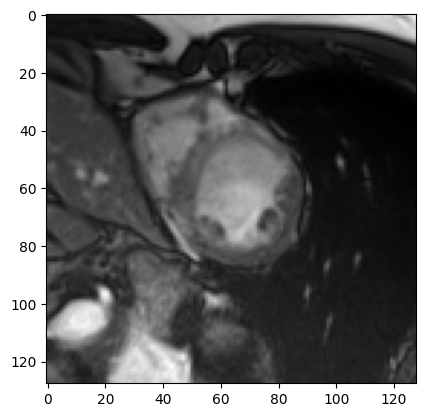

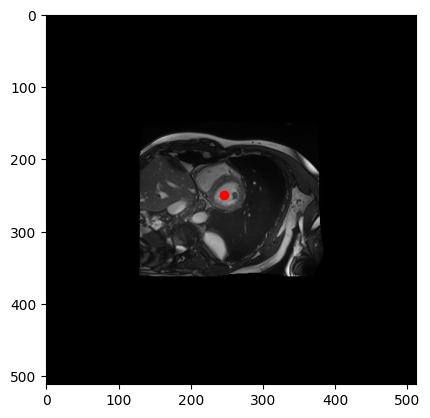

In [4]:
file_to_localize = os.path.join(base_path, "../../Data/ACDC/database/train_numpy/patient055")
Localizer = Localize(file_to_localize)  # path to the time series folder
image = Localizer.get_cropped_image(4)
Localizer.plot_image(image)
Localizer.view_center_of_mass(2)

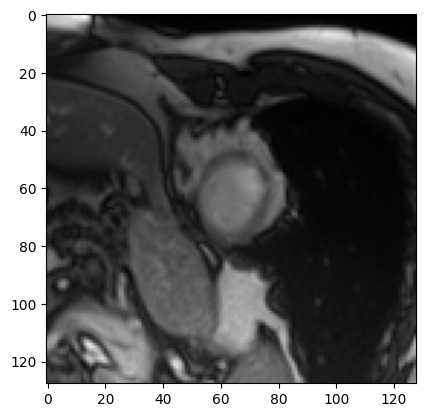

In [5]:
image = Localizer.get_cropped_image(-2)
Localizer.plot_image(image)

In [6]:
def process_acdc_patient(patient_path):
    """
    Process a single patient folder from the ACDC dataset, and apply localization.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        np.ndarray: Array containing pairs of consecutive frames, each with image and mask.
    """
    pattern = r"frame(\d+)_slice_(\d+)"  # Pattern to extract frame and slice numbers from filenames
    slices_dict = {}

    for file in os.listdir(patient_path):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (H, W)

            # Extract slice and frame numbers from the filename
            match = re.search(pattern, file)
            if not match:
                print(f"Error: {file} does not match the expected pattern.")
                continue
            frame = int(match.group(1))
            slice_num = int(match.group(2))

            # Organize frames by slice number
            if slice_num not in slices_dict:
                slices_dict[slice_num] = []
            slices_dict[slice_num].append((frame, data))

    paired_frames = []

    for slice_num, frames in slices_dict.items():
        # Ensure there are at least two frames for pairing
        if len(frames) < 2:
            print(f"Warning: Slice {slice_num} does not have enough frames to pair.")
            continue

        # Pair consecutive frames
        for i in range(len(frames) - 1):
            _, frame1_data = frames[i]
            _, frame2_data = frames[i + 1]

            # Localize both frames
            localized_frame1 = localize_slices(np.expand_dims(frame1_data, axis=0))[0]
            localized_frame2 = localize_slices(np.expand_dims(frame2_data, axis=0))[0]

            # Combine the localized frames into a single pair
            pair = np.stack([localized_frame1, localized_frame2], axis=0)  # Shape: (2, H, W)
            paired_frames.append(pair)

    return np.array(paired_frames)  # Shape: (num_pairs, 2, H, W)

def localize_slices(slice_array):
    """
    Apply the Localize class to localize a set of slices (images and masks).
    
    Args:
        slice_array (np.ndarray): Slices in the shape (num_slices, H, W).
    
    Returns:
        np.ndarray: Localized slices of shape (num_slices, crop_size, crop_size).
    """
    localized_images = []

    # Pass slices directly to Localize without saving to disk
    Localizer = Localize(slice_array)  # Assuming Localize can handle NumPy arrays directly

    # Extract localized images
    for i in range(len(Localizer.array_of_cropped_images)):
        localized_images.append(Localizer.array_of_cropped_images[i])

    return localized_images

def localize_slices(slice_array):
    """
    Apply the Localize class to localize a set of slices (images and masks).

    Args:
        slice_array (np.ndarray): Slices in the shape (num_slices, H, W).

    Returns:
        np.ndarray: Localized slices of shape (num_slices, crop_size, crop_size).
    """
    localized_images = []

    for i in range(slice_array.shape[0]):
        image = slice_array[i]  # Image

        # Save temporary numpy files to feed into Localize (as it expects paths)
        temp_dir = "temp_localization"
        os.makedirs(temp_dir, exist_ok=True)
        temp_file = os.path.join(temp_dir, f"slice_{i}.npy")
        np.save(temp_file, image)

    # Instantiate Localize and localize
    Localizer = Localize(temp_dir)

    for j in range(len(Localizer.array_of_cropped_images)):
        localized_images.append(Localizer.array_of_cropped_images[j])

    # Clean up temp directory
    shutil.rmtree(temp_dir)

    # Combine localized images and masks
    return localized_images

def process_sunnybrook_patient(patient_path):
    """
    Process a single patient folder from the Sunnybrook dataset, and apply localization.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        np.ndarray: Array containing pairs of consecutive frames, each with image and mask.
    """
    pattern = r"frame(\d+)_slice_(\d+)"  # Pattern to extract frame and slice numbers from filenames
    slices_dict = {}

    for file in os.listdir(patient_path):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (H, W)

            # Extract slice and frame numbers from the filename
            match = re.search(pattern, file)
            if not match:
                print(f"Error: {file} does not match the expected pattern.")
                continue
            frame = int(match.group(1))
            slice_num = int(match.group(2))

            # Organize frames by slice number
            if slice_num not in slices_dict:
                slices_dict[slice_num] = []
            slices_dict[slice_num].append((frame, data))

    paired_frames = []

    for slice_num, frames in slices_dict.items():
        # Ensure there are at least two frames for pairing
        if len(frames) < 2:
            print(f"Warning: Slice {slice_num} does not have enough frames to pair.")
            continue

        # Pair consecutive frames
        for i in range(len(frames) - 1):
            _, frame1_data = frames[i]
            _, frame2_data = frames[i + 1]

            # Localize both frames
            localized_frame1 = localize_slices(np.expand_dims(frame1_data, axis=0))[0]
            localized_frame2 = localize_slices(np.expand_dims(frame2_data, axis=0))[0]

            # Combine the localized frames into a single pair
            pair = np.stack([localized_frame1, localized_frame2], axis=0)  # Shape: (2, H, W)
            paired_frames.append(pair)

    return np.array(paired_frames)  # Shape: (num_pairs, 2, H, W)


def load_and_organize_data(input_path, dataset_type):
    """
    Load and organize data from the ACDC and Sunnybrook datasets.
    
    Args:
        input_path (str): Path to the directory containing the dataset folders.
        dataset_type (str): Type of dataset ('ACDC' or 'Sunnybrook').

    Returns:
        np.ndarray: A NumPy array with shape (num_patients, max_num_pairs, 2 frames, H, W).
    """
    all_patient_data = []

    for patient_folder in os.listdir(input_path):
        patient_path = os.path.join(input_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        if dataset_type == 'ACDC':
            print(f"Processing patient {patient_folder} in the ACDC dataset...")
            patient_data = process_acdc_patient(patient_path)
        elif dataset_type == 'Sunnybrook':
            print(f"Processing patient {patient_folder} in the Sunnybrook dataset...")
            patient_data = process_sunnybrook_patient(patient_path)
        else:
            raise ValueError("Unsupported dataset type. Choose 'ACDC' or 'Sunnybrook'.")

        # Add the processed data for this patient to the list
        all_patient_data.append(patient_data)

    return all_patient_data


def load_combined_data(acdc_path, sunnybrook_path):
    """
    Load and combine data from both ACDC and Sunnybrook datasets, ensuring unified per-patient slices.

    Args:
        acdc_path (str): Path to the ACDC dataset.
        sunnybrook_path (str): Path to the Sunnybrook dataset.
        output_path (str): Path to save the combined dataset.

    Returns:
        np.ndarray: Combined patient data as a NumPy array.
    """
    acdc_data_list = load_and_organize_data(acdc_path, 'ACDC')
    sunnybrook_data_list = load_and_organize_data(sunnybrook_path, 'Sunnybrook')

    combined_data_list = acdc_data_list + sunnybrook_data_list
    max_num_pairs = max(len(patient) for patient in combined_data_list)
    sample_shape = combined_data_list[0].shape[1:]
    num_patients = len(combined_data_list)
    combined_data = np.zeros((num_patients, max_num_pairs, *sample_shape), dtype=np.float32)

    for idx, patient_data in tqdm(enumerate(combined_data_list), total=num_patients):
        num_pairs = patient_data.shape[0]
        combined_data[idx, :num_pairs] = patient_data

    print(f"Combined data loaded. Shape: {combined_data.shape}")
    return combined_data




In [7]:
def save_combined_data(combined_data, output_path):
    """
    Saves the combined data to the specified output path. If the data size exceeds 10 GB, 
    it uses memory-mapped file storage to handle large data efficiently.
    Parameters:
    combined_data (numpy.ndarray): The combined data array to be saved.
    output_path (str): The file path where the combined data will be saved.
    Returns:
    None
    Notes:
    - Checks if there is enough free disk space before saving the data.
    - If the data size is larger than 10 GB, it uses numpy.memmap to save the data incrementally.
    - If the output file already exists, it resumes saving from the last saved slice.
    - Prints a warning if there is not enough disk space.
    - Prints a message indicating the data has been saved successfully.
    """
    required_space = combined_data.nbytes
    free_space = shutil.disk_usage("/")[2]

    if free_space < required_space:
        print(f"Warning: Not enough disk space! Needed: {required_space / 1e9:.2f} GB, Available: {free_space / 1e9:.2f} GB")
        return

    if required_space > 10e9:  # Use memmap for large data
        print("Using memmap for large data...")
        memmap_data = np.memmap(output_path, dtype='float32', mode='r+' if os.path.exists(output_path) else 'w+', shape=combined_data.shape)

        # Resume from last saved slice
        start_idx = np.count_nonzero(memmap_data[:, 0, 0, 0] != 0)  # Check how much was saved
        memmap_data[start_idx:] = combined_data[start_idx:]
        memmap_data.flush()
    else:
        np.save(output_path, combined_data)

    print(f"Combined data saved to {output_path}")


In [35]:
def save_combined_data_incremental(combined_data, output_path):
    memmap_data = np.memmap(output_path, dtype='float32', mode='w+', shape=combined_data.shape)
    for i in range(combined_data.shape[0]):
        memmap_data[i] = combined_data[i]
        memmap_data.flush()
    print("Incremental save complete.")


In [8]:
acdc_path = os.path.join(base_path, "../../Data/ACDC/database/train_numpy")
sunnybrook_path = os.path.join(base_path, "../../Data/Sunnybrook/Standardized_Numpy")
output_path = os.path.join(base_path, "../../Data/all_combined_data.npy")

combined_data = load_combined_data(acdc_path, sunnybrook_path)
print(f"Combined data shape: {combined_data.shape}")


Processing patient patient001 in the ACDC dataset...
Processing patient patient002 in the ACDC dataset...
Processing patient patient003 in the ACDC dataset...
Processing patient patient004 in the ACDC dataset...
Processing patient patient005 in the ACDC dataset...
Processing patient patient006 in the ACDC dataset...
Processing patient patient007 in the ACDC dataset...
Processing patient patient008 in the ACDC dataset...
Processing patient patient009 in the ACDC dataset...
Processing patient patient010 in the ACDC dataset...
Processing patient patient011 in the ACDC dataset...
Processing patient patient012 in the ACDC dataset...
Processing patient patient013 in the ACDC dataset...
Processing patient patient014 in the ACDC dataset...
Processing patient patient015 in the ACDC dataset...
Processing patient patient016 in the ACDC dataset...
Processing patient patient017 in the ACDC dataset...
Processing patient patient018 in the ACDC dataset...
Processing patient patient019 in the ACDC data

d:\study\graduation project\GP-2025-Strain\Code\VoxelMorph\../ventricular_short_axis_3label\docs\localize.py:120: RuntimeWarning: invalid value encountered in divide
  x_zscores = (x_distribution - x_mean) / x_std
d:\study\graduation project\GP-2025-Strain\Code\VoxelMorph\../ventricular_short_axis_3label\docs\localize.py:128: RuntimeWarning: invalid value encountered in divide
  y_zscores = (y_distribution - y_mean) / x_std


Processing patient patient053 in the ACDC dataset...
Processing patient patient054 in the ACDC dataset...
Processing patient patient055 in the ACDC dataset...
Processing patient patient056 in the ACDC dataset...
Processing patient patient057 in the ACDC dataset...
Processing patient patient058 in the ACDC dataset...
Processing patient patient059 in the ACDC dataset...
Processing patient patient060 in the ACDC dataset...
Processing patient patient061 in the ACDC dataset...
Processing patient patient062 in the ACDC dataset...
Processing patient patient063 in the ACDC dataset...
Processing patient patient064 in the ACDC dataset...
Processing patient patient065 in the ACDC dataset...
Processing patient patient066 in the ACDC dataset...
Processing patient patient067 in the ACDC dataset...
Processing patient patient068 in the ACDC dataset...
Processing patient patient069 in the ACDC dataset...
Processing patient patient070 in the ACDC dataset...
Processing patient patient071 in the ACDC data

100%|██████████| 195/195 [01:39<00:00,  1.97it/s]


Combined data loaded. Shape: (195, 435, 2, 128, 128)
Combined data shape: (195, 435, 2, 128, 128)


In [36]:
output_path = os.path.join(base_path, "../../Data/all_combined_data_1.npy")
save_combined_data_incremental(combined_data, output_path)

Incremental save complete.


In [27]:
save_combined_data(combined_data, output_path)

Using memmap for large data...
Combined data saved to d:\study\graduation project\GP-2025-Strain\Code\VoxelMorph\../../Data/all_combined_data.npy


In [29]:
print(f"File size: {os.path.getsize(output_path) / 1e6:.2f} MB")

File size: 11118.18 MB


In [34]:
try:
    partial_data = np.memmap(output_path, dtype='float32', mode='r')
    reshaped_data = partial_data.reshape(195, 435, 2, 128, 128)  # Your expected shape
    print(f"Recovered shape: {reshaped_data.shape}")
except Exception as e:
    print("Failed to reshape partial data:", e)


Recovered shape: (195, 435, 2, 128, 128)


In [31]:
num_patients, max_num_pairs, channels, H, W = combined_data.shape
reshaped_data = partial_data.reshape(num_patients, max_num_pairs, channels, H, W)
print(f"Recovered shape: {reshaped_data.shape}")


Recovered shape: (195, 435, 2, 128, 128)


In [38]:
if os.path.exists(output_path):
    loaded_data = np.memmap(output_path, dtype='float32', mode='r', shape=(195, 435, 2, 128, 128))
    print(f"Loaded data shape: {loaded_data.shape}")
    assert loaded_data.shape == combined_data.shape, "Saved data shape mismatch!"
    print("Save verified.")


Loaded data shape: (195, 435, 2, 128, 128)
Save verified.


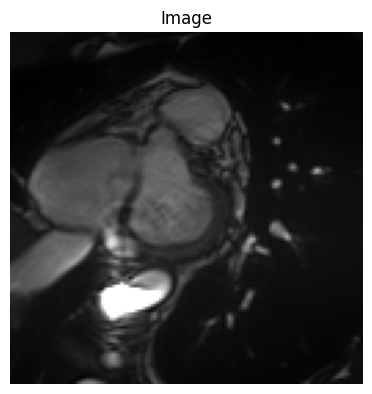

In [40]:
def plot_sample_slice(combined_data, patient_index=0, stage=0, slice_index=0):
    """
    Plots a sample slice from the combined dataset.

    Args:
        combined_data (np.ndarray): Combined dataset of shape 
                                     (num_patients, max_slices, 2, 128, 128).
        patient_index (int): Index of the patient to visualize. Default is 0.
        stage (int): Index of the stage to visualize (0 = end-systole, 1 = end-diastole). Default is 0.
        slice_index (int): Index of the slice to visualize. Default is 0.
    """
    try:
        # Extract the image and mask
        sample_image = combined_data[patient_index, slice_index, stage]

        # Create the plots
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.show()

    except IndexError:
        print("Invalid index provided. Ensure the patient_index, stage, and slice_index are within bounds.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
plot_sample_slice(loaded_data, patient_index=45, stage=1, slice_index=6)


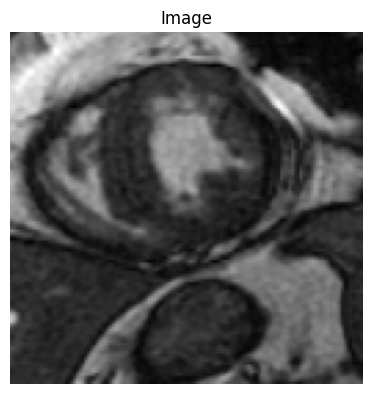

In [41]:
plot_sample_slice(combined_data, patient_index=160, stage=0, slice_index=7)

In [23]:
# Make sure there is no zero value image frames in the dataset if there is any print the patient index and slice index 
zero_images = []
for i in range(combined_data.shape[0]):
    for j in range(combined_data.shape[1]):
        if np.all(combined_data[i, j] == 0):
            zero_images.append((i, j))

if zero_images:
    print("Zero value image frames found:")
    for patient_index, slice_index in zero_images:
        print(f"Patient index: {patient_index}, Slice index: {slice_index}")
else:
    print("No zero value image frames found.")
            


Zero value image frames found:
Patient index: 0, Slice index: 290
Patient index: 0, Slice index: 291
Patient index: 0, Slice index: 292
Patient index: 0, Slice index: 293
Patient index: 0, Slice index: 294
Patient index: 0, Slice index: 295
Patient index: 0, Slice index: 296
Patient index: 0, Slice index: 297
Patient index: 0, Slice index: 298
Patient index: 0, Slice index: 299
Patient index: 0, Slice index: 300
Patient index: 0, Slice index: 301
Patient index: 0, Slice index: 302
Patient index: 0, Slice index: 303
Patient index: 0, Slice index: 304
Patient index: 0, Slice index: 305
Patient index: 0, Slice index: 306
Patient index: 0, Slice index: 307
Patient index: 0, Slice index: 308
Patient index: 0, Slice index: 309
Patient index: 0, Slice index: 310
Patient index: 0, Slice index: 311
Patient index: 0, Slice index: 312
Patient index: 0, Slice index: 313
Patient index: 0, Slice index: 314
Patient index: 0, Slice index: 315
Patient index: 0, Slice index: 316
Patient index: 0, Slice 

In [22]:
%whos

Variable                     Type          Data/Info
----------------------------------------------------
Localize                     type          <class 'localize.Localize'>
Localizer                    Localize      <localize.Localize object at 0x0000025DE7417850>
acdc_path                    str           d:\study\graduation proje<...>ACDC/database/train_numpy
base_path                    str           d:\study\graduation proje<...>25-Strain\Code\VoxelMorph
combined_data                ndarray       195x435x2x128x128: 2779545600 elems, type `float32`, 11118182400 bytes (10603.125 Mb)
file_path                    str           d:\study\graduation proje<...>s_3label\docs\localize.py
file_to_localize             str           d:\study\graduation proje<...>se/train_numpy/patient055
free_space                   int           922255081472
i                            int           194
image                        ndarray       128x128: 16384 elems, type `float64`, 131072 bytes (128.0 kb